In [1]:
import numpy as np 
import pandas as pd 
from google.cloud import bigquery
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn import metrics
import eli5
from eli5.sklearn import PermutationImportance
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

In [2]:
client = bigquery.Client()

Using Kaggle's public dataset BigQuery integration.


In [25]:
# the number of new users in each year
query = '''
        SELECT extract (year from creation_date) as year,
               count(id) as n_new_user
        FROM `bigquery-public-data.stackoverflow.users` 
        GROUP BY year
        ORDER BY year
        '''
query_job = client.query(query)
new_user = query_job.to_dataframe()      

# the number of users who have been inactive for at least one year,with the last access in 2019 or before
query = '''
        SELECT extract(year from last_access_date) as year,
               count(id) as n_inact_user
        FROM `bigquery-public-data.stackoverflow.users` 
        GROUP BY year
        HAVING year < 2020
        ORDER BY year
        '''
query_job = client.query(query)
inact_user = query_job.to_dataframe()    

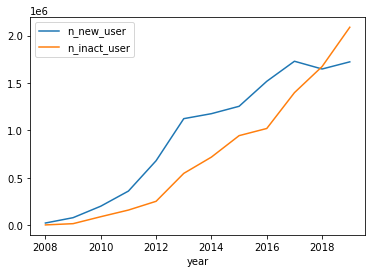

In [30]:
df = pd.merge(new_user,inact_user,on='year',how='inner')
df.set_index('year')[['n_new_user','n_inact_user']].plot()

In [ ]:
# to predict when inactive users become inactive (whether become inactive in one year), foucs on users:
# 1) who have been inactive for at least one year, with the last access in 2019 or before
# 2) who started early and thus have a long history. Users who start in 2008 are a small sample. So choose users starting in 2009

In [18]:
# each user's question posting and getting feedback from other users in each year
query = '''
        WITH a AS
        (SELECT owner_user_id,
                EXTRACT(year from creation_date) as year, 
                count(id) as n_question, 
                count(accepted_answer_id) as n_accepted_answer, 
                avg(answer_count) as mean_answer_count,
                avg(comment_count) as mean_comment_count,
                avg(favorite_count) as mean_favorite_count,
                avg(view_count) as mean_view_count,
                avg(score) as mean_score
         FROM `bigquery-public-data.stackoverflow.posts_questions`
         GROUP BY owner_user_id,year 
        )
        SELECT a.owner_user_id, a.year,a.n_question,
               a.n_accepted_answer,a.mean_answer_count,a.mean_comment_count,
               a.mean_favorite_count,a.mean_view_count,a.mean_score,
               EXTRACT(year from creation_date) as start_year,
               EXTRACT(year from last_access_date) as quit_year
        FROM `bigquery-public-data.stackoverflow.users` AS b
        INNER JOIN a
        ON a.owner_user_id = b.id
        WHERE EXTRACT(year from b.creation_date) = 2009 and \
        EXTRACT(year from b.last_access_date) < 2020
        ORDER BY a.owner_user_id,a.year
        '''
query_job = client.query(query)
question_feedback_start_2009 = query_job.to_dataframe() 

In [19]:
# each user's answering questions posted by others in each year
query = '''
        WITH a AS
        (SELECT owner_user_id,
                EXTRACT(year from creation_date) as year, 
                count(id) as n_answer
         FROM `bigquery-public-data.stackoverflow.posts_answers`
         GROUP BY owner_user_id,year 
        )
        SELECT a.owner_user_id, a.year,a.n_answer,
               EXTRACT(year from creation_date) as start_year,
               EXTRACT(year from last_access_date) as quit_year
        FROM `bigquery-public-data.stackoverflow.users` AS b
        INNER JOIN a
        ON a.owner_user_id = b.id
        WHERE EXTRACT(year from b.creation_date) = 2009 and \
        EXTRACT(year from b.last_access_date) < 2020
        ORDER BY a.owner_user_id,a.year
        '''
query_job = client.query(query)
answer_start_2009 = query_job.to_dataframe()

In [20]:
# each user's comment making in each year
query = '''
        WITH a AS
        (SELECT user_id as owner_user_id,
                EXTRACT(year from creation_date) as year, 
                count(id) as n_comment 
         FROM `bigquery-public-data.stackoverflow.comments`
         GROUP BY owner_user_id,year 
        )
        SELECT a.owner_user_id, a.year,a.n_comment,
               EXTRACT(year from creation_date) as start_year,
               EXTRACT(year from last_access_date) as quit_year
        FROM `bigquery-public-data.stackoverflow.users` AS b
        INNER JOIN a
        ON a.owner_user_id = b.id 
        WHERE EXTRACT(year from b.creation_date) = 2009 and \
        EXTRACT(year from b.last_access_date) < 2020
        ORDER BY a.owner_user_id,a.year
        '''
query_job = client.query(query)
comment_start_2009 = query_job.to_dataframe() 

In [21]:
# merge questions and feedback, answering, and commenting
start_2009 = pd.merge(answer_start_2009,comment_start_2009,on=['owner_user_id','year'],how='outer')
start_2009 = pd.merge(start_2009,question_feedback_start_2009,on=['owner_user_id','year'],how='outer')

In [22]:
# generate target and features
start_2009['last_before_quit'] = (start_2009['year'] == \
start_2009.groupby('owner_user_id')['year'].transform('max')).astype(int)
start_2009.fillna(0,inplace=True)

start_2009['mean_accepted_answer'] = start_2009['n_accepted_answer']/start_2009['n_question']

start_2009 = start_2009.sort_values(['owner_user_id','year'])
for var in ['n_comment','n_question','n_answer','mean_accepted_answer',\
        'mean_answer_count','mean_comment_count','mean_favorite_count',\
        'mean_view_count','mean_score']:
    start_2009['l_'+var] = start_2009.groupby('owner_user_id')[var].shift(1)

In [23]:
# drop obs. with missing values and drop those users with only one obs.
start_2009_copy = start_2009.dropna()
start_2009_copy['n_obs'] = start_2009_copy.groupby('owner_user_id')['year'].transform('count')
start_2009_copy = start_2009_copy[start_2009_copy.n_obs>1]

In [24]:
# mild imbalance: 20% minority
start_2009_copy['last_before_quit'].value_counts()

0    21091
1     5313
Name: last_before_quit, dtype: int64

In [6]:
# validation
X = start_2009_copy[['l_n_comment','l_n_question','l_n_answer','l_mean_accepted_answer',\
        'l_mean_answer_count','l_mean_comment_count','l_mean_favorite_count',\
        'l_mean_view_count','l_mean_score']]
y= start_2009_copy['last_before_quit']

train_X, val_X, train_y, val_y = train_test_split(X,y,random_state=0)

In [7]:
# XGB
model = XGBClassifier(objective='binary:logistic',max_depth=10,n_estimators=100,
                      learning_rate=0.1) 
model.fit(train_X,train_y)
preds = model.predict(val_X)
score = metrics.accuracy_score(val_y,preds)
print('accuracy:',score)

accuracy: 0.7979094076655052


In [8]:
# permutation importance
perm = PermutationImportance(model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight,Feature
0.0035 ± 0.0020,l_n_answer
0.0035 ± 0.0036,l_mean_view_count
0.0025 ± 0.0015,l_mean_accepted_answer
0.0019 ± 0.0019,l_n_comment
0.0018 ± 0.0018,l_mean_score
0.0017 ± 0.0039,l_n_question
0.0011 ± 0.0025,l_mean_comment_count
0.0009 ± 0.0026,l_mean_answer_count
0.0005 ± 0.0004,l_mean_favorite_count


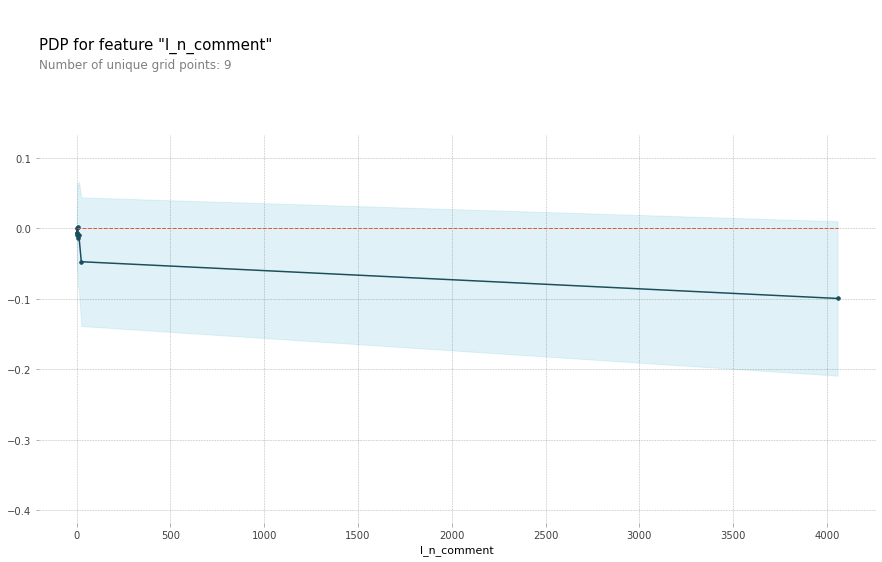

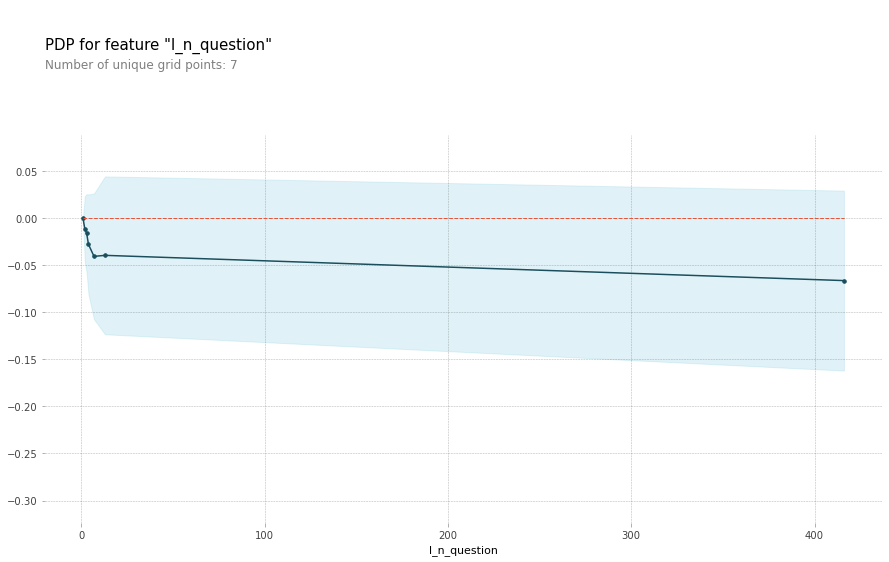

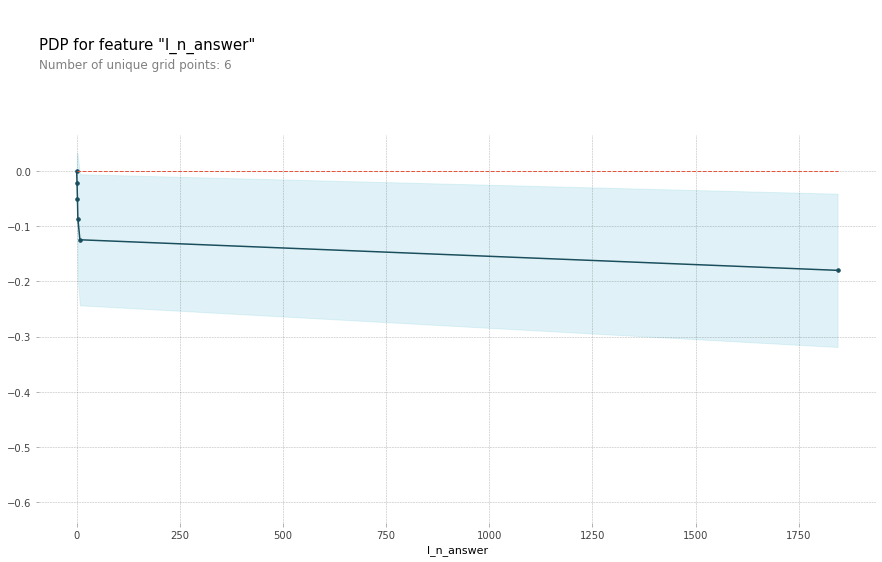

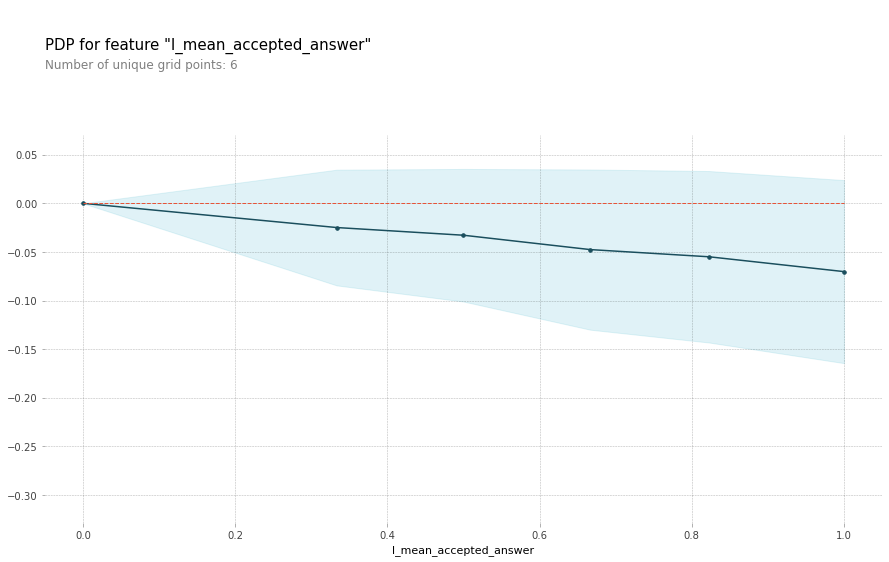

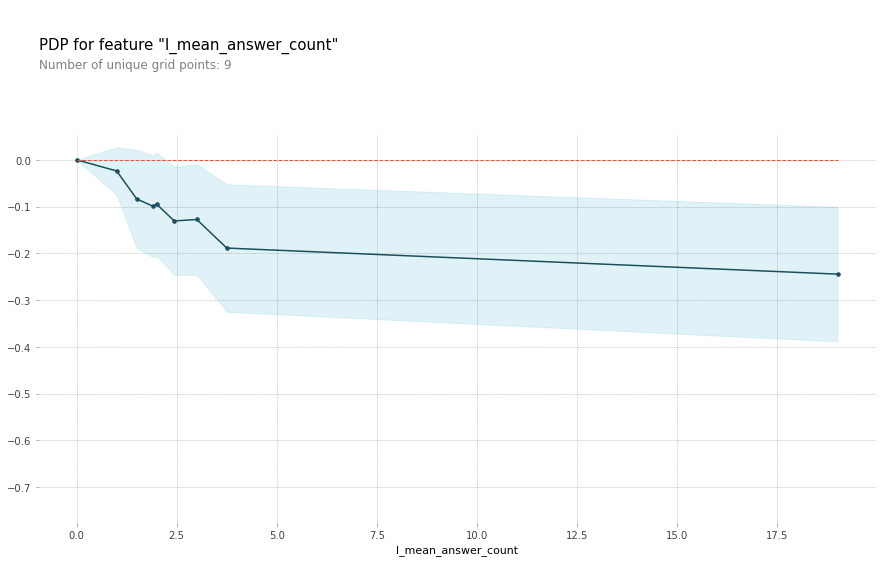

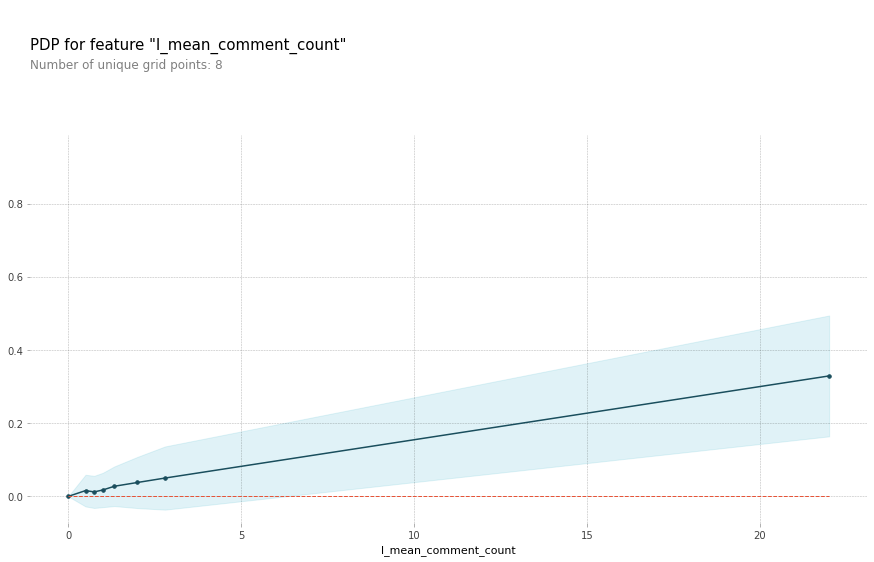

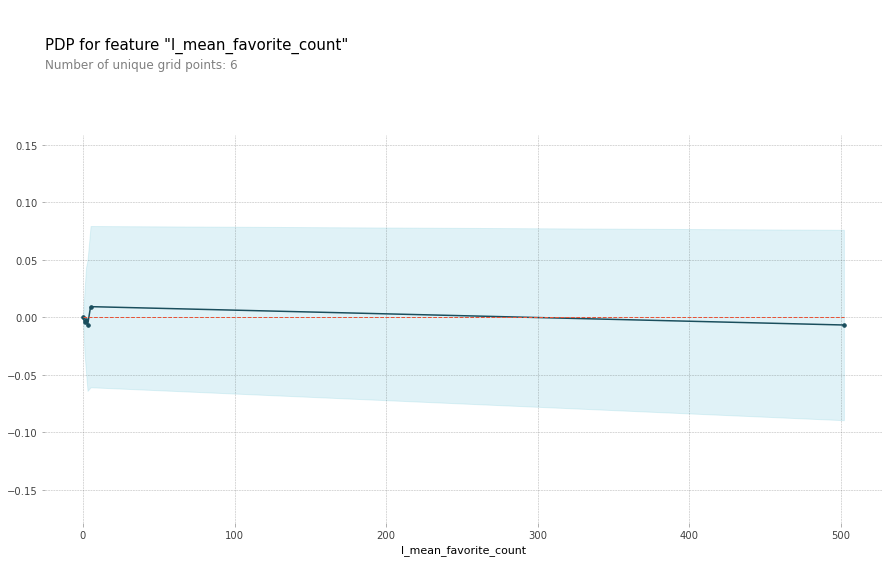

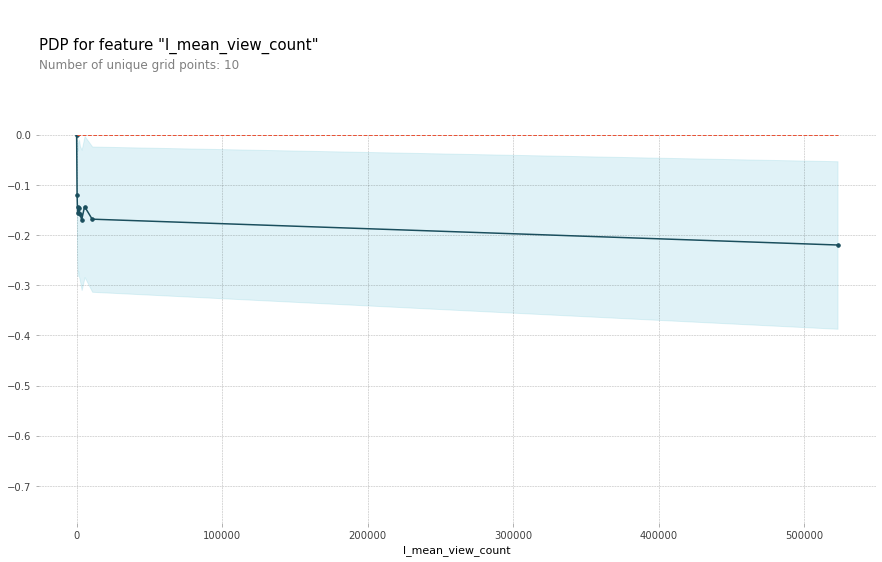

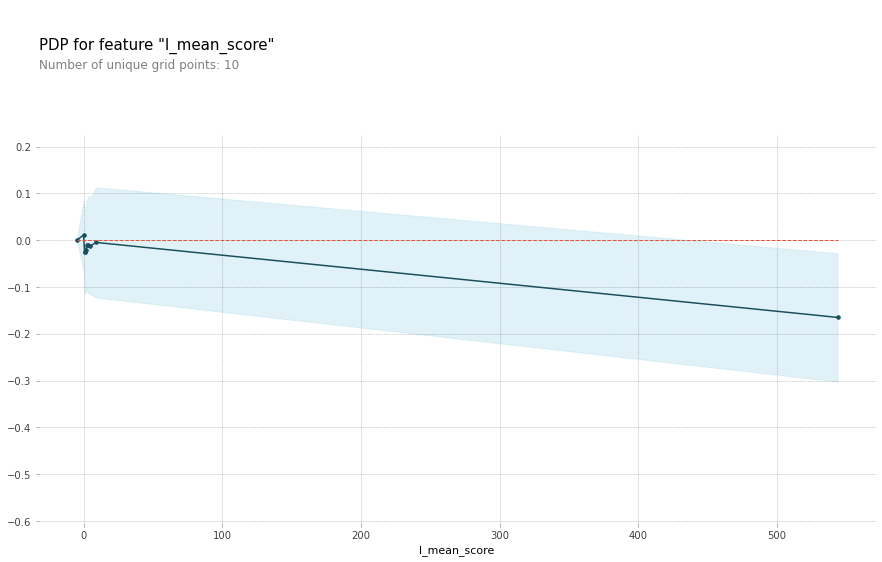

In [17]:
# partial dependence plot
features = ['l_n_comment','l_n_question','l_n_answer','l_mean_accepted_answer',\
        'l_mean_answer_count','l_mean_comment_count','l_mean_favorite_count',\
        'l_mean_view_count','l_mean_score']
for f in features:
    pdp_goals = pdp.pdp_isolate(model, dataset=val_X,model_features=features,\
                                feature=f)
    pdp.pdp_plot(pdp_goals,f)
    plt.show()